# Maximum Entropy Approximation - Joint distribution P(m, p)

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import dill
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/MaxEnt_approx_joint/'
datadir = '../../data/csv_maxEnt_dist/'

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{avg}[1]{\left\langle #1 \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
---

# The joint distribution $P(m, p)$ using MaxEnt.

So far we used the MaxEnt approach to approximate the marginal distributions for mRNA $P(m)$ and protein $P(p)$. In reality since the protein copy number depends on the mRNA count we have a joint distribution $P(m, p)$. By definition the marginals we have computed are of the form
$$
P(m) \equiv \sum_p P(m, p),
$$
and
$$
P(p) \equiv \sum_m P(m, p),
$$

This joint distribution could contain relevant information that we lose when performing these marginalizations. Therefore in this notebook we will use the exact same MaxEnt approach as before to compute the joint distribution.

For the case of the joing distribution we have moments for the mRNA marginal distribution
$$
\ee{m^i} \equiv \sum_m \sum_p m^i P(m, p),
$$
with $i \in \{1, 2, 3\}$ and equivalent moments for the protein distribution
$$
\ee{p^j} \equiv \sum_m \sum_p p^j P(m, p),
$$
for $j \in \{1, 2\}$.

We also know the steady-state value of cross-correlations of the form
$$
\ee{m p} \equiv \sum_m \sum_p m p P(m, p).
$$

Using these moments we can follow the exact same strategy to compute the MaxEnt approximation of the joint distribution.

**Note**: The reason we do not include $\ee{p^3}$ or higher order correlations such as $\ee{m^2 p}$ is because the fitting becomes numerically unstable.

# Two-state unregulated promoter
---

As an exercise to test the performance of this approximation let's fit the Maximum entropy model to the two-state unregulated promoter model. 

Let's first define the three functions needed to implement the first two moment constraints.

In [2]:
# Marginalized moments
# mRNA
def m1(x):
    return x[0]

def m2(x):
    return x[0]**2

def m3(x):
    return x[0]**3

# protein
def p1(x):
    return x[1]

def p2(x):
    return x[1]**2

# Cross correlations
def mp_fn(x):
    return x[0] * x[1]

Now let's define the parameters for the *lacUV5* unregulated promoter.

In [3]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

We can now use the `maxnetropy` package to fit the maximum entropy model.
Let's do it systematically incrementing the number of moments used for the approximation.

In [4]:
# Put the constraint functions into an array
features = [m1, m2, m3, # mRNA
            p1, p2, # protein
            mp_fn] # cross correlations

# Extract the parameters in order to feed them to the moment functions
m_param = ['kp_on', 'kp_off', 'rm', 'gm']
p_param = ['kp_on', 'kp_off', 'rm', 'gm', 'rp', 'gp']
par_m = [par_UV5.get(x) for x in m_param]
par_p = [par_UV5.get(x) for x in p_param]

# Write down the constraints
# mRNA
mRNA_moments = [chann_cap.first_unreg_m(*par_m),\
                chann_cap.second_unreg_m(*par_m),\
                chann_cap.third_unreg_m(*par_m)]
# Protein
protein_moments = [chann_cap.first_unreg_p(*par_p),\
                   chann_cap.second_unreg_p(*par_p)]
# Cross-correlations
correlations = [chann_cap.mp_unreg_p(*par_p)]

constraints = np.array(mRNA_moments + protein_moments + correlations)

We will now define the mRNA and protein sample space based on the value of the first and second moment.

In [5]:
# Extract moments
mRNA_mean = mRNA_moments[0]
protein_mean = protein_moments[0]

# Compute standard deviation
mRNA_std = np.sqrt(mRNA_moments[1] - mRNA_mean**2)
protein_std = np.sqrt(protein_moments[1] - protein_mean**2)

# Compute range
std_factor = 4 # factor defining how many std away to take

mRNA_range = [int(x) for x in [mRNA_mean - std_factor * mRNA_std,
              mRNA_mean + std_factor * mRNA_std]]
protein_range = [int(x) for x in [protein_mean - std_factor * protein_std,
                 protein_mean + std_factor * protein_std]]

# Generate sample space
mRNA_space = np.arange(*mRNA_range)
protein_space = np.arange(*protein_range)

# Eliminate negative numbers
mRNA_space = mRNA_space[mRNA_space >= 0]
protein_space = protein_space[protein_space >= 0]

# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

Now let's fit the distribution using `maxentropy`!

In [6]:
fit_dist = False
if fit_dist:
    # Define the minimum entropy 
    model = MinDivergenceModel(features, samplespace, vectorized=False,
                               verbose=False)
    model.algorithm = 'Powell'
    model.tol = 1E-4
    model.paramstol = 1E-4
    model.maxiter = 1000
    model.callingback = True
    # Change the dimensionality of the array
    X = np.reshape(constraints, (1, -1))
    # Fit the model
    model.fit(X)
    # Change dill setting to allow the export of the functions
    dill.settings['recurse'] = True

    # Open file to save functions
    with open(datadir + 'two_state_Pmp_maxEnt.dill', 'wb') as file:
        dill.dump(model, file)
        dill.dump(mRNA_space, file)
        dill.dump(protein_space, file)

We can load the saved distribution.

In [44]:
# Load model and sample space
with open(datadir + 'two_state_Pmp_maxEnt.dill', 'rb') as file:
    model = dill.load(file)
    mRNA_space = dill.load(file)
    protein_space = dill.load(file)

# Convert probability to 2D matrix
Pmp = model.probdist().reshape(len(mRNA_space), len(protein_space)).T
Pmp.shape

(15842, 40)

And plot the marginals

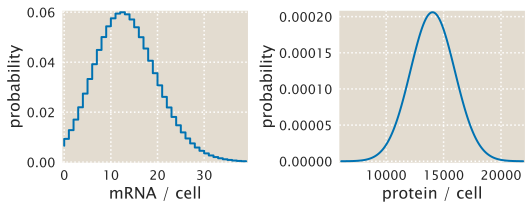

In [8]:
# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3))

# Plot mRNA marginal
ax[0].plot(mRNA_space, Pmp.sum(axis=0), drawstyle='steps')
ax[0].set_xlabel('mRNA / cell')
ax[0].set_ylabel('probability')
ax[0].margins(0.01)

# Plot protein marginal
ax[1].plot(protein_space, Pmp.sum(axis=1), drawstyle='steps')
ax[1].set_xlabel('protein / cell')
ax[1].set_ylabel('probability')
ax[1].margins(0.01)

plt.tight_layout()
plt.savefig(figdir + 'MaxEnt_marginals_PMF_unreg.pdf', bbox_inches='tight')

Let's plot the joint distribution as well.

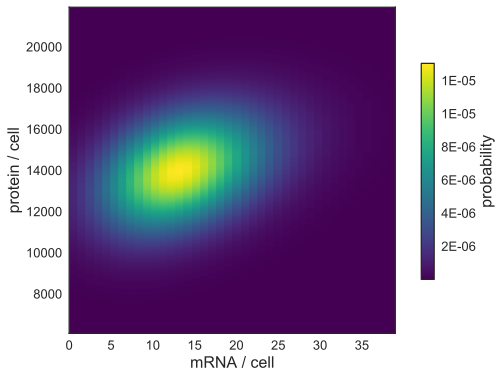

In [9]:
# Define the extent of axis and aspect ratio of heatmap
extent = [mRNA_space.min(), mRNA_space.max(),
          protein_space.min(), protein_space.max()]
aspect = (mRNA_space.max() - mRNA_space.min()) /\
         (protein_space.max() - protein_space.min())
    
with sns.axes_style('white'):
    # Initialize figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 6)) 
    
    # Plot joint distribution
    cax = ax.matshow(Pmp, cmap='viridis', origin='lower',
               extent=extent, aspect=aspect)
    # Move ticks to the bottom of the plot
    ax.xaxis.tick_bottom()
    
    # Label axis
    ax.set_xlabel('mRNA / cell')
    ax.set_ylabel('protein / cell')

    # Generate a colorbar with the concentrations
    cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])

    # Add colorbar, make sure to specify tick locations to match 
    # desired ticklabels
    cbar = fig.colorbar(cax, cax=cbar_ax, format='%.0E')

    # Label colorbar
    cbar.set_label('probability')
    
# Save fig
plt.savefig(figdir + 'MaxEnt_joint_PMF_unreg.pdf', bbox_inches='tight')

Let's make a combined plot that includes both the joint and the marginal distributions. For that we will use the defined function in the `chann_cap` utils.

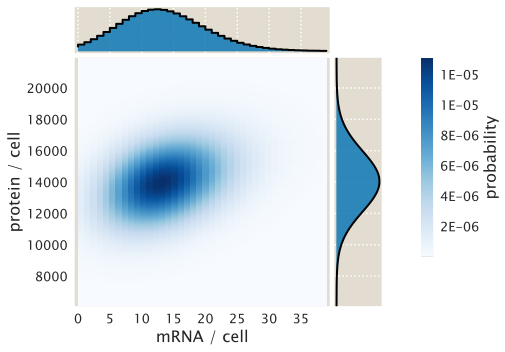

In [10]:
chann_cap.joint_marginal_plot(mRNA_space, protein_space, Pmp, 
                              xlabel='mRNA / cell', ylabel='protein / cell')

---
# Three-state regulated promoter.
---

Let's now define a function that computes the steady-state moments as a function of the chemical master equation parameters and the thermodynamic parameters.

In [24]:
def moment_ss_reg(moment_fun, C, rep, eRA, 
                 k0=2.7E-3, kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 rp=0.0975, gp=97.53,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5):
    '''
    Computes the mRNA and/or protein steady state moments given a list
    of functions (moments) and all the chemical master equation
    parameters.
    
    Parameters
    ----------
    moment_fun : list.
        List containing the functions to be used to compute the steady
        state moments.
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    moments_num : array-like. len(C) x len(moments)
        Array containing all the required moments for each of the indicated
        concentrations of inducer
    '''
    # Convert C into np.array
    C = np.array(C)
    
    # Calculate the repressor on rate including the MWC model
    kr_on = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    
    # Compute the repressor off-rate based on the on-rate and the 
    # binding energy
    kr_off = chann_cap.kr_off_fun(eRA, k0, kp_on, kp_off, Nns)
    
    # Generate array with variables
    param = [kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp]
    
    # Initialie array to save the moments
    moment_num = np.zeros(len(moment_fun))
    
    # Loop through functions to compute moments
    for i, fun in enumerate(moment_fun):
        # Find the number of variables in function. mRNA functions have
        # 6 arguments while protein functions have 8.
        arg_num = fun.__code__.co_argcount
        
        # Compute moment
        moment_num[i] = fun(*param[:arg_num])
        
    # Return moments
    return moment_num

Let's test this function. For this we need to define the parameters for the regulated promoter.

In [25]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)

# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5_reg['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5_reg['rp'] = 1000 * par_UV5_reg['gp']

print(par_UV5_reg)

{'kp_on': 5.5, 'kp_off': 28.9, 'rm': 87.6, 'gm': 1, 'Nns': 4600000.0, 'ka': 139, 'ki': 0.53, 'epsilon': 4.5, 'k0': 0.9507042253521127, 'gp': 0.09753521126760563, 'rp': 97.53521126760563}


Now we can test the function.

In [28]:
# List the functions
moment_fun = [chann_cap.first_reg_m,
              chann_cap.second_reg_m,
              chann_cap.third_reg_m,
              chann_cap.first_reg_p,
              chann_cap.second_reg_p,
              chann_cap.mp_reg_p]

# Add repressor copy number and binding energy
par = par_UV5_reg.copy()
par['rep'] = 260 # repressors / cell
par['eRA'] = -13.9  # kBT

moment_ss_reg(moment_fun, 0, **par)

array([  3.72059765e-01,   1.61381193e+00,   1.16813282e+01,
         3.72059765e+02,   2.73361472e+05,   2.72989412e+02])

The function seems to be working properly.

For the previous example we gave the `maxentropy` `minDivergenceModel` function a list of functions to compute the products related to each of the moments. This function also accepts:
> `array: 2d array of shape (m, n) Matrix F representing evaluations of f_i(x) on all points x_1,...,x_n in the sample space, such as the output of FeatureTransformer(...).transform(X)`.

Therefore we will now generate this `Matrix F` to speed up the computation of the distributions when using the same sample space for different sets of parameters.

Let's first define the sample space, then build this matrix with the constraints.

In [69]:
# Define sample space
mRNA_space = np.arange(0, 40)
protein_space = np.arange(0, 2.3E4)
# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# List all functions used to compute the products associated with each of
# the constraints
feature_fun = [m1, m2, m3, p1, p2, mp_fn]

# Initialize matrix to save all the features that are fed to the 
# maxentropy function
features = np.zeros([len(feature_fun), len(samplespace)])

# Loop through constraints and compute features
for i, feat in enumerate(feature_fun):
    features[i, :] = [feat(x) for x in samplespace]

Having build this list let's test everything by computing the joint distribution for the O2 - R260 strain in the absence of inducer.

In [70]:
# List the functions
moment_fun = [chann_cap.first_reg_m,
              chann_cap.second_reg_m,
              chann_cap.third_reg_m,
              chann_cap.first_reg_p,
              chann_cap.second_reg_p,
              chann_cap.mp_reg_p]

# Add repressor copy number and binding energy
par = par_UV5_reg.copy()
par['rep'] = 260 # repressors / cell
par['eRA'] = -13.9  # kBT

constraints = moment_ss_reg(moment_fun, 0, **par)

fit_dist = True
if fit_dist:
    # Define the minimum entropy 
    model = MinDivergenceModel(features, samplespace)
    model.algorithm = 'Powell'
    model.tol = 1E-4
    model.paramstol = 1E-4
    model.maxiter = 1000
    model.callingback = True
    # Change the dimensionality of the array
    X = np.reshape(constraints, (1, -1))
    # Fit the model
    model.fit(X)
    # Change dill setting to allow the export of the functions
    dill.settings['recurse'] = True

    # Open file to save functions
    with open(datadir + 'O2_R260_0mM_Pmp_maxEnt.dill', 'wb') as file:
        dill.dump(model, file)
        dill.dump(mRNA_space, file)
        dill.dump(protein_space, file)

In [71]:
# Load model and sample space
with open(datadir + 'O2_R260_0mM_Pmp_maxEnt.dill', 'rb') as file:
    model = dill.load(file)
    mRNA_space = dill.load(file)
    protein_space = dill.load(file)

# Convert probability to 2D matrix
Pmp = model.probdist().reshape(len(mRNA_space), len(protein_space)).T
Pmp.shape

(23000, 40)

In [72]:
chann_cap.joint_marginal_plot(mRNA_space, protein_space, Pmp, 
                              xlabel='mRNA / cell', ylabel='protein / cell')